In [1]:
%pip install -U langchain langchain-openai langchain-pinecone pinecone-client 

  Using cached langchain_openai-1.1.10-py3-none-any.whl.metadata (3.1 kB)
  Using cached langchain_pinecone-0.2.13-py3-none-any.whl.metadata (8.6 kB)
  Using cached pinecone_client-6.0.0-py3-none-any.whl.metadata (3.4 kB)
  Using cached openai-2.21.0-py3-none-any.whl.metadata (29 kB)
  Using cached pinecone-7.3.0-py3-none-any.whl.metadata (9.5 kB)
  Using cached simsimd-6.5.13-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (70 kB)
  Using cached pinecone_plugin_interface-0.0.7-py3-none-any.whl.metadata (1.2 kB)
  Using cached jiter-0.13.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.2 kB)
  Using cached tqdm-4.67.3-py3-none-any.whl.metadata (57 kB)
  Using cached pinecone_plugin_assistant-1.8.0-py3-none-any.whl.metadata (30 kB)
  Using cached aiohttp_retry-2.9.1-py3-none-any.whl.metadata (8.8 kB)
  Using cached packaging-24.2-py3-none-any.whl.metadata (3.2 kB)
Using cached langchain_openai-1.1.10-py3-none-any.whl (87 

In [2]:
%pip install langchain langchain-text-splitters langchain-community bs4


[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install -qU langchain-google-genai


[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
%pip install langchain-huggingface sentence-transformers tf-keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## 2. Build a RAG agent with LangChain

To start building our RAG, we need to initialize the environment and install everything necessary, from langchain to the embedding specifications.

In this case, we will use the lightest option offered by hugging-face, and we will also use gemin-ai for queries.

In [4]:
import os
import getpass
from langchain.chat_models import init_chat_model

In [11]:
if not os.environ.get("GOOGLE_API_KEY"):
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for GeminiAI: ")

model = init_chat_model("google_genai:gemini-2.5-flash-lite")

from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

Here, we call the API key that we have in our .env file using the OS library, initialize our chat model by indicating which one, and specify the embedding method.

In [22]:
from langchain_pinecone import PineconeVectorStore
from langchain_core.vectorstores import InMemoryVectorStore
from pinecone import Pinecone
from dotenv import load_dotenv
import os

load_dotenv()

pc = Pinecone(os.environ.get("PINECONE_API_KEY"))
index = pc.Index(host="https://tdse-huggingface-3rr3n9h.svc.aped-4627-b74a.pinecone.io")


# vector_store = InMemoryVectorStore(embeddings)
vector_store = PineconeVectorStore(embedding=embeddings, index=index)

Using bs4 we will be able to obtain the html information of the page we are going to consult and save it.

In [23]:
import bs4 
from langchain_community.document_loaders import WebBaseLoader

bs4_strainer = bs4.SoupStrainer(class_=("post-tittle","post-header","post-content"))

loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)

docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43047


In [24]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


Here, we will proceed to divide all the text into parts of text or rather chunks

In [25]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    add_start_index=True
)

all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 63 sub-documents.


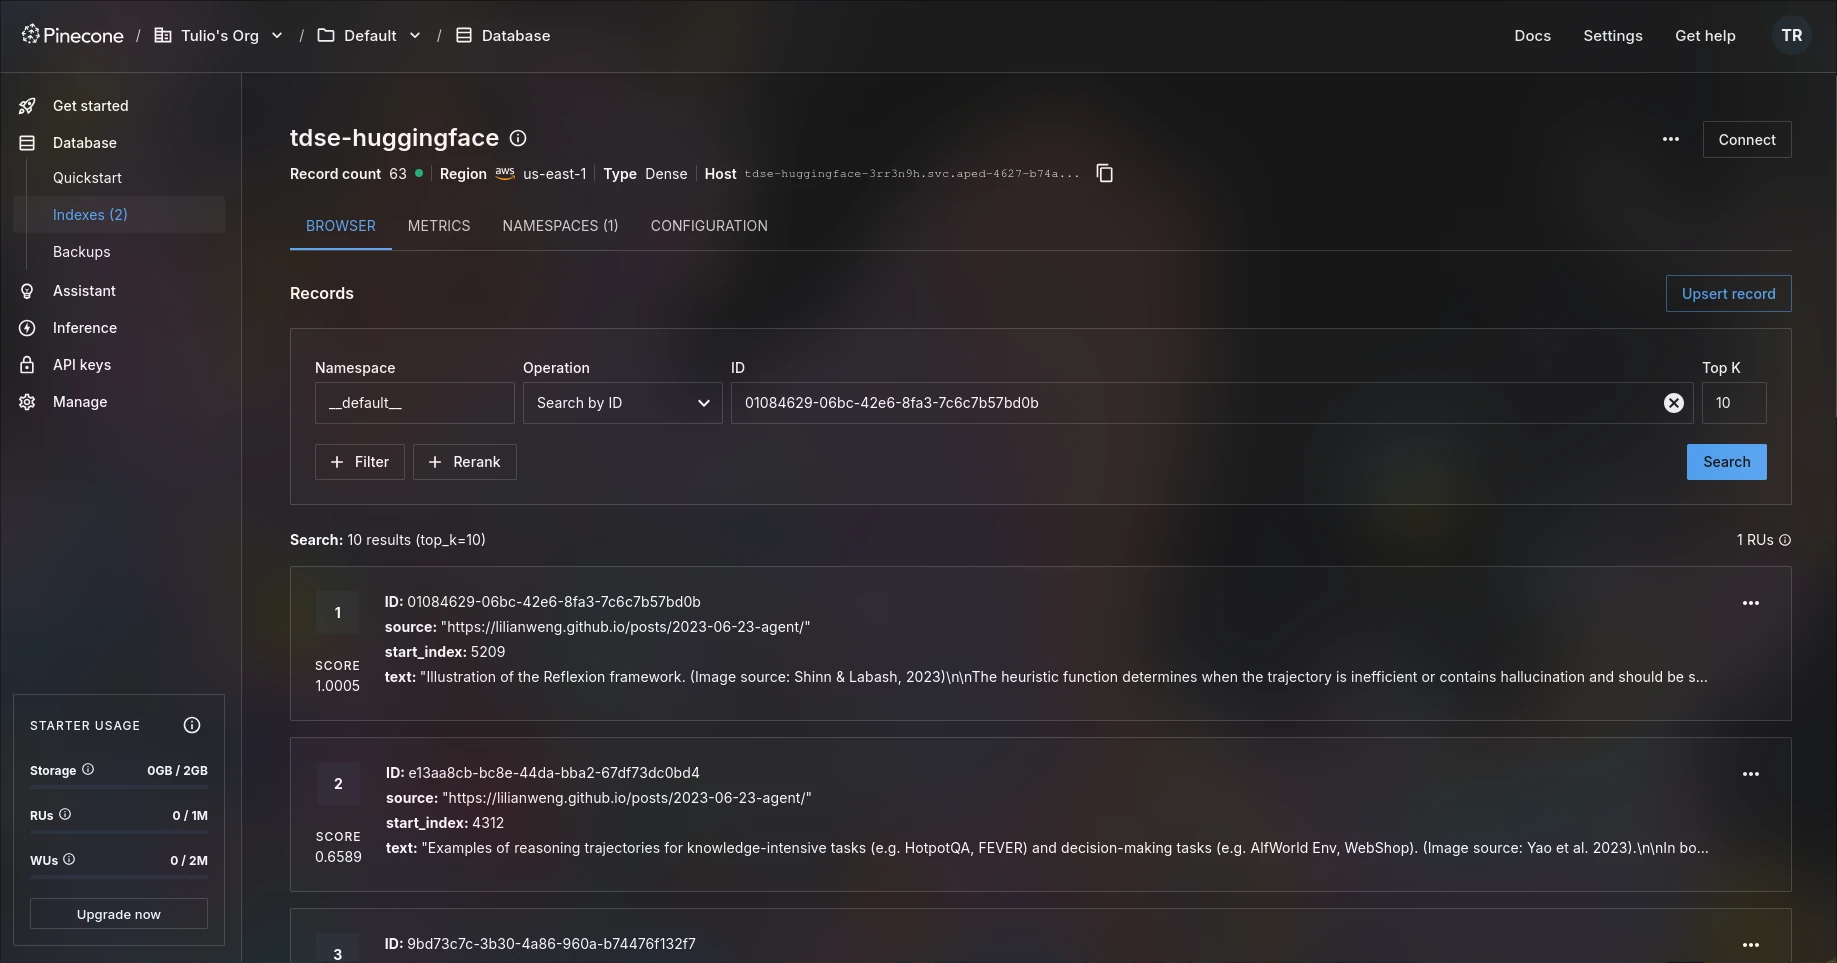

After this, we will add all the documents to our vector database in Pinecone where we display the information

In [26]:
documents_id = vector_store.add_documents(documents=all_splits)

In [27]:
print(documents_id[:3])

['3ad6c424-ae63-457e-8604-12d3805d4458', '253e7c5c-8969-401f-a681-9050d99a9dfe', 'f293b47a-df65-4580-b629-b3afd98b3aa9']


We define the tool that the agent will use.

In [28]:
from langchain.tools import tool

@tool(response_format="content_and_artifact")
def retrieve_context(query: str):
    """Retrieve information to help answer a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

We specify the general prompt

In [29]:
from langchain.agents import create_agent

tools = [retrieve_context]

prompt = (
    "You have access to a tool that retrieves context from a blog post. "
    "Use the tool to help answer user queries."
)

agent = create_agent(model, tools, system_prompt=prompt)

We run the query to test and get the message.

In [30]:
query = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

for event in agent.stream(
    {"messages": [{"role": "user", "content": query}]},
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve_context (c7791a82-17dd-4d21-990b-084fc95fd010)
 Call ID: c7791a82-17dd-4d21-990b-084fc95fd010
  Args:
    query: standard method for Task Decomposition
================================= Tool Message =================================
Name: retrieve_context

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578.0}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on

We can see this on the Langsmith website

## LangSmith Previsualization

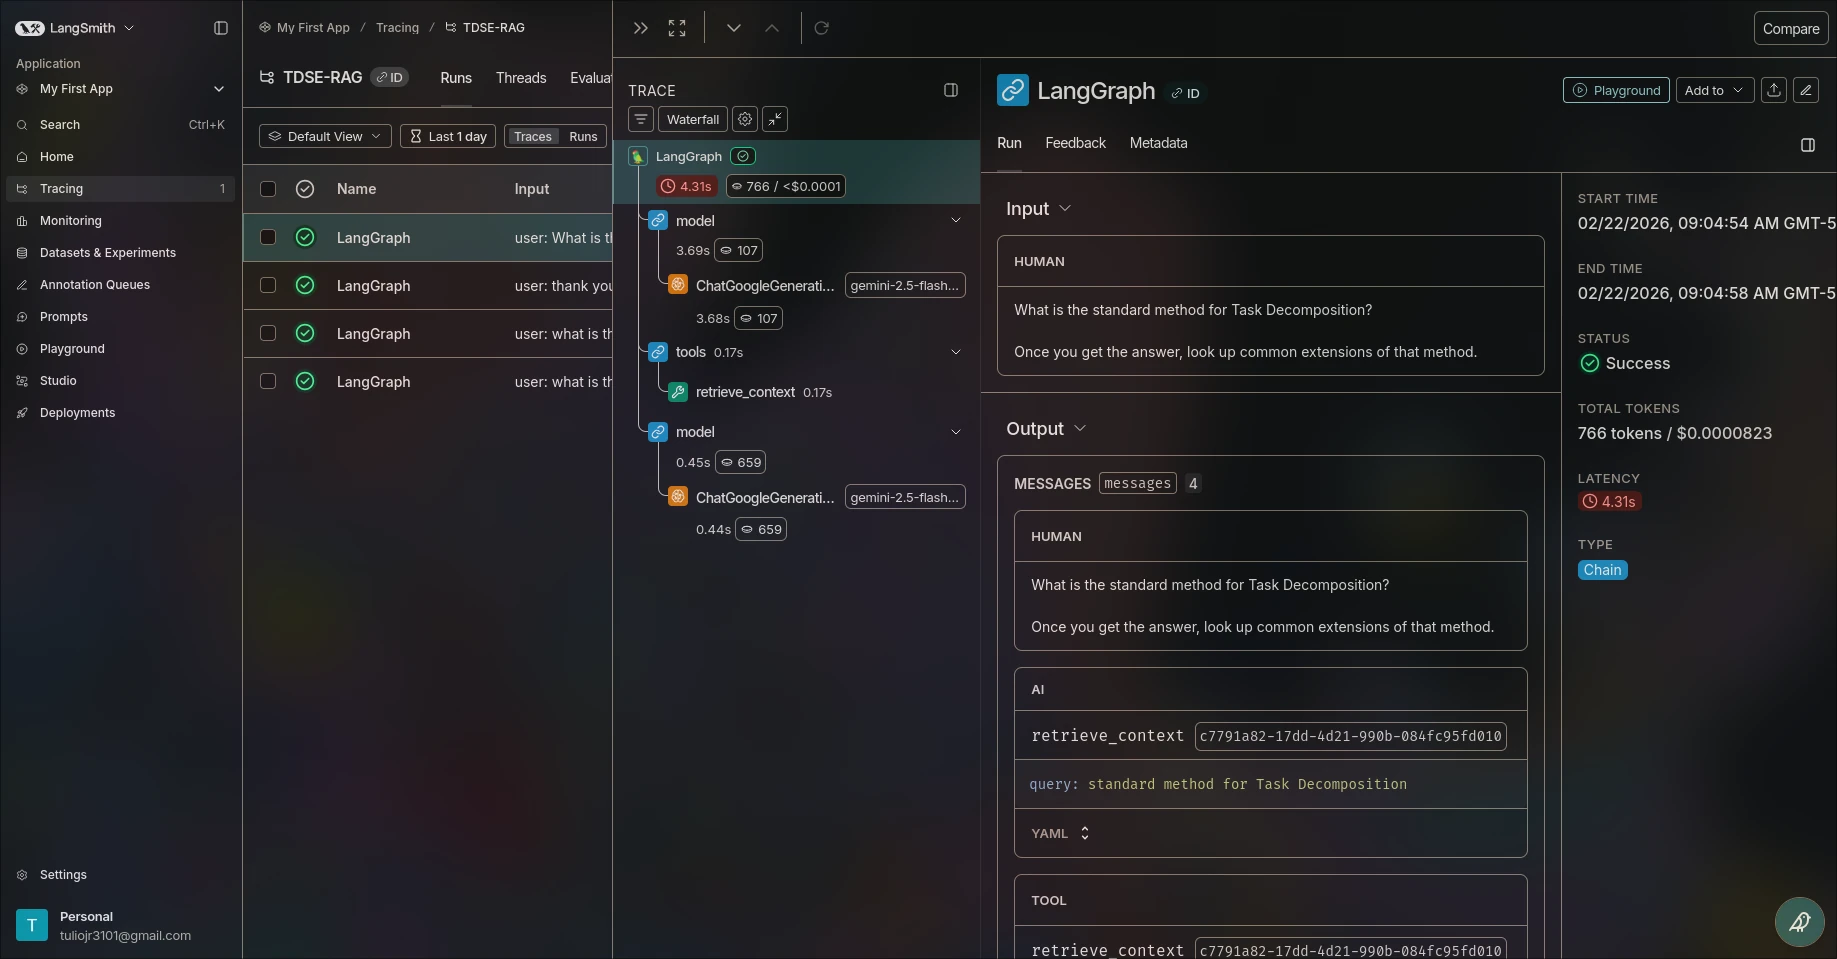